### IEMS 394

#### Data Pipeline
Objective: Load and clean data, save as pickle.

In [2]:
%%time
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point, Polygon
import pandas as pd
from tqdm import tqdm
import os, geojson, multiprocessing, datetime, time
import concurrent.futures
# %matplotlib tk

os.chdir('/Users/saifbhatti/Desktop/Northwestern/sy1920/s20/iems394/client-data/cleaned_data')

with open('us_counties_2010.json', encoding = "ISO-8859-1") as f:
    gj = geojson.load(f)
    
    
selected_states = ['TX','CA','MN']

CPU times: user 2.7 s, sys: 262 ms, total: 2.96 s
Wall time: 2.93 s


### Vision (end goals)

- Data Cleaning (python file) 
    - read in appropriate csv files that have been cleaned
    - convert to dataframe
    - pickle
- AMPL szn (python file)
    - unpickle
    - AMPLpy code that uses the dataframes as decision parameters
- Visualisation (ipynb)
    - either 

### Files

Vehicle Data:
- EV_Ranges.csv
- vehicle_ages.csv
- vehicles_available.csv
- trip_purpose_miles.csv
- HI_vehicles.csv
- HEV_model-sales.csv
- PEV_model-sales.csv
- Distance.csv



#### Import and Clean Vehicle Data

In [3]:
df = pd.read_csv('HEV_model-sales.csv',skiprows=1,thousands=',')
df.drop('Total',axis=1,inplace=True)
df.drop(df.index[df.shape[0]-1],inplace=True)
df.set_index(df['Vehicle'],inplace=True)
df.drop('Vehicle',axis=1,inplace=True)
df = df.applymap(lambda x: x.replace('-','0'))
df = df.applymap(lambda x: x.replace(",", ""))
# df = df.applymap(lambda x: x=int(x))
cols=[i for i in df.columns if i not in ['Vehicle']]
for col in cols:
    df[col]=pd.to_numeric(df[col])
hybrid_df = df

In [4]:
hybrid_df['total']= hybrid_df.sum(axis=1) #total sum per column
# hybrid_df['total'].plot(kind='bar',x='name',y='sales volume')
# hybrid_df

In [5]:
df = pd.read_csv('PEV_model-sales.csv',skiprows=1,thousands=',')
df.drop('Total',axis=1,inplace=True)
df.drop(df.index[df.shape[0]-1],inplace=True)
df.set_index(df['Vehicle'],inplace=True)
df.drop('Vehicle',axis=1,inplace=True)
# df.replace(to_replace='-',value=';')
df = df.applymap(lambda x: x.replace('-','0'))
df = df.applymap(lambda x: x.replace(",", ""))
cols=[i for i in df.columns if i not in ['Type']]
for col in cols:
    df[col]=pd.to_numeric(df[col])
electric_df = df

In [6]:
EV_ranges_df =  pd.read_csv('EV_ranges.csv')

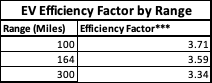

In [7]:
df = pd.read_csv('electric_fuel_stations.csv')
electric_fuel_df = df
df.head()

,Unnamed: 0,Fuel Type Code,Station Name,Street Address,City,State,ZIP,Status Code,Groups With Access Code,Latitude,...,ID,Owner Type Code,Open Date,EV Connector Types,Country,Access Code,Facility Type,EV Pricing,EV On-Site Renewable Source,County
0,0,ELEC,City of Sacramento - Capitol Parking Garage,1015 L St,Sacramento,CA,95814,E,Public,38.578380,...,1498,LG,8/20/2018,NEMA520,US,public,PAY_GARAGE,NaN,NaN,Sacramento
1,1,ELEC,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,CA,91352,E,Private,34.248319,...,1517,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN,Los Angeles
2,2,ELEC,Southern California Edison - Rosemead Office B...,2244 Walnut Grove Ave,Rosemead,CA,91770,E,Private,34.050745,...,1520,T,08/01/2011,J1772 NEMA520,US,private,UTILITY,NaN,NaN,Los Angeles
3,3,ELEC,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,E,Public,34.040570,...,1523,P,8/30/1995,J1772,US,public,PARKING_GARAGE,NaN,NaN,Los Angeles
4,4,ELEC,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,CA,90012,E,Private,34.058476,...,1525,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN,Los Angeles


In [8]:
# df['point'] = df['Longitude'] + df['Latitude']
df['Points'] = list(zip(df['Longitude'], df['Latitude']))
# df.tail(20)
df.head()

,Unnamed: 0,Fuel Type Code,Station Name,Street Address,City,State,ZIP,Status Code,Groups With Access Code,Latitude,...,Owner Type Code,Open Date,EV Connector Types,Country,Access Code,Facility Type,EV Pricing,EV On-Site Renewable Source,County,Points
0,0,ELEC,City of Sacramento - Capitol Parking Garage,1015 L St,Sacramento,CA,95814,E,Public,38.578380,...,LG,8/20/2018,NEMA520,US,public,PAY_GARAGE,NaN,NaN,Sacramento,"(-121.4926, 38.57838020000001)"
1,1,ELEC,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,CA,91352,E,Private,34.248319,...,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN,Los Angeles,"(-118.3879714, 34.24831915)"
2,2,ELEC,Southern California Edison - Rosemead Office B...,2244 Walnut Grove Ave,Rosemead,CA,91770,E,Private,34.050745,...,T,08/01/2011,J1772 NEMA520,US,private,UTILITY,NaN,NaN,Los Angeles,"(-118.081014, 34.050745)"
3,3,ELEC,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,E,Public,34.040570,...,P,8/30/1995,J1772,US,public,PARKING_GARAGE,NaN,NaN,Los Angeles,"(-118.268762, 34.04057)"
4,4,ELEC,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,CA,90012,E,Private,34.058476,...,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN,Los Angeles,"(-118.24819, 34.058476)"


In [9]:
def geo_map(x):
    '''
    geo_map takes pandas Series object constructed in the format (longitude, latitude).
    Taking this as the point, a geo.json file is imported containing all US counties from the 2010 census as polygons.
    It computes whether the point is within a polygon, and returns a list of all matches. 
    If a point is not matched, it returns None.
    '''
    point = Point(x)
    for i in range(len(gj['features'])):
        polygon = shape(gj['features'][i]['geometry'])
        if polygon.contains(point):
            return gj['features'][i]['properties']['NAME']

In [10]:
def geo_two(x):
    '''
    geo_map takes pandas Series object constructed in the format (longitude, latitude).
    Taking this as the point, a geo.json file is imported containing all US counties from the 2010 census as polygons.
    It computes whether the point is within a polygon, and returns a list of all matches. 
    If a point is not matched, it returns None.
    '''
    counties = []
    for i in tqdm(x):
        point = Point(x)
        for i in range(len(gj['features'])):
            polygon = shape(gj['features'][i]['geometry'])
            if polygon.contains(point):
                counties.append(gj['features'][i]['properties']['NAME'])

In [11]:
counties = []
points_list = list(df['Points'])
# for i in tqdm(points_list):
#     counties.append(geo_map(i))

In [12]:
# electric_fuel_df['County'] = counties

In [13]:
# electric_fuel_df.to_csv('electric_fuel_stations.csv')

In [14]:
# electric_fuel_df

In [14]:
electric_df.to_pickle("./dummy.pkl")

### Convert data from zipcode to county.

In [15]:
tx_ev_vehicle_registered = pd.read_csv('vehicle_reg/tx_ev_registrations_public.csv')
print(len(tx_ev_vehicle_registered['ZIP Code'].unique()))
print(len(tx_ev_vehicle_registered))
tx_ev_vehicle_registered.head()

1325
74143


,ZIP Code,DMV ID,Vehicle Name,Registration Valid Date
0,3106,1,Tesla Model S,03/06/2019
1,3106,1,Tesla Model S,03/06/2019
2,3106,1,Tesla Model S,03/06/2019
3,3106,1,Tesla Model S,03/06/2019
4,3106,1,Tesla Model S,03/06/2019


In [16]:
mn_ev_vehicle_registered = pd.read_csv('vehicle_reg/mn_ev_registrations_public.csv')
mn_ev_vehicle_registered.drop(['VIN Prefix','VIN Model Year'],inplace=True,axis=1)
print(len(mn_ev_vehicle_registered['ZIP Code'].unique()))
print(len(mn_ev_vehicle_registered))
mn_ev_vehicle_registered.head()

600
29248


,DMV ID,ZIP Code,Registration Expiration Date,Registration Valid Date
0,6,55347.0,01/12/2020,30/01/2020
1,6,55432.0,01/12/2020,30/01/2020
2,6,55330.0,01/07/2020,30/01/2020
3,6,56377.0,01/04/2020,30/01/2020
4,6,55109.0,01/12/2020,30/01/2020


In [17]:
result = pd.concat([mn_ev_vehicle_registered, tx_ev_vehicle_registered], axis=0)
print(len(result['ZIP Code'].unique()))
print(result.shape)
result.head()

1906
(103391, 5)


,DMV ID,ZIP Code,Registration Expiration Date,Registration Valid Date,Vehicle Name
0,6,55347.0,01/12/2020,30/01/2020,NaN
1,6,55432.0,01/12/2020,30/01/2020,NaN
2,6,55330.0,01/07/2020,30/01/2020,NaN
3,6,56377.0,01/04/2020,30/01/2020,NaN
4,6,55109.0,01/12/2020,30/01/2020,NaN


In [18]:
us_zips = pd.read_csv('uszips.csv')
print(us_zips.shape)
us_zips.head()

(33099, 18)


,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico


In [19]:
# len(us_zips[(us_zips['zip'] > 70000) & (us_zips['zip'] < 90000)])

In [20]:
us_zips.columns

Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'zcta',
       'parent_zcta', 'population', 'density', 'county_fips', 'county_name',
       'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
       'military', 'timezone'],
      dtype='object')

In [21]:
new = pd.merge(result, us_zips, how='inner', left_on='ZIP Code', right_on='zip')

In [22]:
new['state_id'].unique()

array(['MN', 'CA', 'OH', 'MI', 'WI', 'IL', 'OR', 'MO', 'TX', 'NJ', 'AZ',
       'CT', 'NE', 'FL', 'ID', 'CO', 'MD', 'NY', 'VA', 'IA', 'WY', 'MA',
       'GA', 'WA', 'NH', 'PA', 'DC', 'NC', 'IN', 'KS', 'LA', 'OK', 'UT',
       'NM', 'NV', 'KY', 'SC', 'AR', 'AK'], dtype=object)

In [23]:
len(new[(new['state_id'] == 'TX') | (new['state_id'] == 'MN')])

97888

In [24]:
new.shape[0]

101278

In [25]:
new = new[(new['state_id'] == 'TX') | (new['state_id'] == 'MN')]
new['state_id'].unique()

array(['MN', 'TX'], dtype=object)

In [26]:
new.columns

Index(['DMV ID', 'ZIP Code', 'Registration Expiration Date',
       'Registration Valid Date', 'Vehicle Name', 'zip', 'lat', 'lng', 'city',
       'state_id', 'state_name', 'zcta', 'parent_zcta', 'population',
       'density', 'county_fips', 'county_name', 'county_weights',
       'county_names_all', 'county_fips_all', 'imprecise', 'military',
       'timezone'],
      dtype='object')

In [27]:
new.groupby('state_id').count()

,DMV ID,ZIP Code,Registration Expiration Date,Registration Valid Date,Vehicle Name,zip,lat,lng,city,state_name,...,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
state_id,,,,,,,,,,,,,,,,,,,,,
MN,29051,29051,29045,29048,6,29051,29051,29051,29051,29051,...,29051,29051,29051,29051,29051,29051,29051,29051,29051,29051
TX,68837,68837,4,68837,68833,68837,68837,68837,68837,68837,...,68837,68837,68837,68837,68837,68837,68837,68837,68837,68837


In [28]:
new.to_csv('ev_registration_county.csv')

In [29]:
cali = pd.read_csv('california_car_data.csv')
cali['Fuel'].unique()

/Users/saifbhatti/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['Gasoline', 'Diesel and Diesel Hybrid', 'Battery Electric',
       'Other', 'Flex-Fuel', 'Hybrid Gasoline', 'Natural Gas',
       'Plug-in Hybrid', 'Hydrogen Fuel Cell'], dtype=object)

In [30]:
cali.head()

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,10/1/2018,90000,2006,Gasoline,OTHER/UNK,Light,1
1,10/1/2018,90000,2014,Gasoline,OTHER/UNK,Light,1
2,10/1/2018,90000,2016,Gasoline,OTHER/UNK,Light,1
3,10/1/2018,90000,2017,Gasoline,OTHER/UNK,Light,1
4,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,Heavy,55


Within the `IRS Individual Tax Income` dataset, the following columns are extracted:
- `STATE`: the relevant state the form was filed in.
- `zipcode`: the relevant zipcode the form was filed in.
- `NI`: Number of Returns.
- `A02650`: Total Income Amount.

Run `!curl https://www.irs.gov/pub/irs-soi/17zpallagi.csv -o irs.csv` to download.

In [31]:
irs = pd.read_csv('irs.csv') #read in the csv
irs = irs[['STATE','zipcode','A02650','N1']] #only keep a few columns (detailed above)
irs = irs.rename(columns={'A02650': 'total_income_amt', 'N1': 'return_count'})
irs.columns

Index(['STATE', 'zipcode', 'total_income_amt', 'return_count'], dtype='object')

In [32]:
irs['avg_income_amt'] = irs['total_income_amt'] / irs['return_count']

In [33]:
ranked_irs = irs.groupby('STATE').sum()
ranked_irs.sort_values(by='avg_income_amt', ascending=False).head()

,zipcode,total_income_amt,return_count,avg_income_amt
STATE,,,,
TX,751356162,1.834322e+09,24686880.0,1.090974e+06
CA,828823507,3.131749e+09,35656240.0,1.078311e+06
NY,117768024,1.726421e+09,19164470.0,9.463213e+05
PA,141540136,8.694608e+08,12340460.0,7.837033e+05
FL,183958530,1.497832e+09,19986410.0,7.564661e+05


In [34]:
irs = irs[irs['STATE'].isin(selected_states)] #keep only relevant states
irs.groupby('STATE').sum()

,zipcode,total_income_amt,return_count,avg_income_amt
STATE,,,,
CA,828823507,3.131749e+09,35656240.0,1.078311e+06
MN,265321122,4.220840e+08,5484850.0,4.426392e+05
TX,751356162,1.834322e+09,24686880.0,1.090974e+06


In [35]:
e85 = pd.read_csv('e85_fuel_stations.csv')

In [36]:
e85['Points'] = list(zip(e85['Longitude'], e85['Latitude']))
e85

,Fuel Type Code,Station Name,City,State,ZIP,Latitude,Longitude,ID,E85 Blender Pump,Points
0,E85,Sioux Valley Co-op - Cenex,Watertown,SD,57201,44.904113,-97.130798,1447,True,"(-97.130798, 44.904113)"
1,E85,F&M Co-op Oil,Madison,SD,57042,44.007690,-97.146785,1451,True,"(-97.146785, 44.007690000000004)"
2,E85,Kum & Go #113,Ames,IA,50010,42.034894,-93.575925,1470,True,"(-93.575925, 42.034894)"
3,E85,Texaco - Highway 34 Truckstop,West Burlington,IA,52655,40.825493,-91.208355,1479,False,"(-91.20835500000001, 40.825493)"
4,E85,Conoco - Convenient Food Mart,Jefferson City,MO,65109,38.588189,-92.255887,1480,False,"(-92.255887, 38.588189)"
...,...,...,...,...,...,...,...,...,...,...
3556,E85,76 - Foothill Petroleum Inc.,La Crescenta,CA,91214,34.232154,-118.253509,156016,False,"(-118.25350900000001, 34.232154)"
3557,E85,Conoco - 130 Truck Stop,Cinnaminson,NJ,8077,40.006900,-74.975100,156023,False,"(-74.9751, 40.0069)"
3558,E85,BP,Fort Mill,SC,29708,35.030458,-80.966548,156024,False,"(-80.966548, 35.030458)"
3559,E85,Rutter's,Inwood,WV,25428,39.404224,-78.016428,156025,False,"(-78.01642778, 39.40422416)"


In [39]:
counties = []
points_list = list(e85['Points'])
for i in tqdm(points_list): 
    counties.append(geo_map(i))
e85['County'] = counties

  3%|▎         | 113/3561 [00:08<04:23, 13.06it/s]


KeyboardInterrupt: 

In [38]:
e85.groupby('County').count().sort_values(by='City', ascending=False).head(20)

KeyError: 'County'

In [84]:
# e85[e85['County']=="Los Angeles"]
e85.groupby('State').count().sort_values(by='Fuel Type Code', ascending=False).head(10)

,Fuel Type Code,Station Name,City,ZIP,Latitude,Longitude,ID,E85 Blender Pump,Points,County
State,,,,,,,,,,
MN,406,406,406,406,406,406,406,406,406,406
IA,291,291,291,291,291,291,291,291,291,291
IL,266,266,266,266,266,266,266,266,266,266
MI,237,237,237,237,237,237,237,237,237,237
WI,232,232,232,232,232,232,232,232,232,232
TX,231,231,231,231,231,231,231,231,231,231
IN,221,221,221,221,221,221,221,221,221,221
CA,181,181,181,181,181,181,181,181,181,181
OH,173,173,173,173,173,173,173,173,173,173


In [40]:
centroids = pd.read_csv('county_centroids.csv')

In [54]:
centroids['Latitude'] = centroids['Latitude'].apply(lambda x: x.strip('°'))
centroids['Longitude'] = centroids['Longitude'].apply(lambda x: x.strip('°'))
centroids['Longitude'] = centroids['Longitude'].apply(lambda x: x.replace('–','-'))
centroids['Latitude'] = centroids['Latitude'].apply(lambda x: x.replace('+',''))

In [55]:
centroids


,State,FIPS,County,County Seat,Unnamed: 4,Land Area kmsq,Land Area misq,Total Area kmsq,Total Area misq,Latitude,Longitude
0,AL,1001,Autauga,Prattville,"54,571","1,539.58",594.436,"1,565.36",604.388,32.536382,-86.644490
1,AL,1003,Baldwin,Bay Minette,"182,265","4,117.52","1,589.78","5,250.71","2,027.31",30.659218,-87.746067
2,AL,1005,Barbour,Clayton,"27,457","2,291.82",884.876,"2,342.68",904.515,31.870670,-85.405456
3,AL,1007,Bibb,Centreville,"22,915","1,612.48",622.582,"1,621.77",626.169,33.015893,-87.127148
4,AL,1009,Blount,Oneonta,"57,322","1,669.96",644.776,"1,685.12",650.628,33.977448,-86.567246
...,...,...,...,...,...,...,...,...,...,...,...
3138,WY,56037,Sweetwater,Green River,"43,806","27,004.90","10,426.65","27,171.78","10,491.09",41.660339,-108.875676
3139,WY,56039,Teton,Jackson,"21,294","10,347.98","3,995.38","10,920.25","4,216.33",44.049321,-110.588102
3140,WY,56041,Uinta,Evanston,"21,118","5,390.45","2,081.26","5,406.79","2,087.57",41.284726,-110.558947
3141,WY,56043,Washakie,Worland,"8,533","5,797.82","2,238.55","5,808.58","2,242.70",43.878831,-107.669052


stuff to do today:
    
- focus on 394, clean up this file, solve the problem, make a new document
- then focus on renoster, create a list of tasks we have to do. pick 1 simple format and stick to it.